# Chương trình huấn luyện và đánh giá độ chính xác của mô hình

In [19]:
from __future__ import absolute_import, division, print_function, unicode_literals
from keras.preprocessing import sequence
from keras.datasets import imdb
from keras import layers, models
from keras.models import Sequential
from keras import layers
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import random
from keras import optimizers
from keras.layers import SimpleRNN, Dense, Dropout
from keras.layers import Bidirectional
from keras.callbacks import Callback, ModelCheckpoint
import matplotlib.pyplot as plt
import os
import sys
import argparse
import itertools
from sklearn.metrics import confusion_matrix

In [20]:
def make_label(text):
    with open("label.txt", "w") as f:
         f.write(text)
    f.close()

In [7]:
def rm_zero_sequences_endlist(txtlist):
    numbers = txtlist
    if (numbers[-1] ==0 and numbers[-2] ==0 and numbers[-3] ==0 and numbers[-4] ==0 and numbers[-5] ==0 and numbers[-6] ==0
    and numbers[-7] ==0 and numbers[-8] ==0 and numbers[-9] ==0 and numbers[-10] ==0 and numbers[-11] ==0 and numbers[-12] ==0
    and numbers[-13] ==0 and numbers[-14] ==0 and numbers[-15] ==0 and numbers[-16] ==0 and numbers[-17] ==0 and numbers[-18] ==0
    and numbers[-19] ==0 and numbers[-20] ==0 and numbers[-21] ==0 and numbers[-22] ==0 and numbers[-23] ==0 and numbers[-24] ==0
    and numbers[-25] ==0 and numbers[-26] ==0 and numbers[-27] ==0 and numbers[-28] ==0 and numbers[-29] ==0 and numbers[-30] ==0
    and numbers[-31] ==0 and numbers[-32] ==0 and numbers[-33] ==0 and numbers[-34] ==0 and numbers[-35] ==0 and numbers[-36] ==0
    and numbers[-37] ==0 and numbers[-38] ==0 and numbers[-39] ==0 and numbers[-40] ==0 and numbers[-41] ==0 and numbers[-42] ==0):
        numbers = numbers[:-42]
    return numbers

## Xử lý dữ liệu

In [8]:
def load_data(dirname):
    if dirname[-1]!='/':
        dirname=dirname+'/'
    listfile=os.listdir(dirname) #list cac file trong input 
    X = []
    Y = []
    XT = []
    YT = []
    for file in listfile: #Lướt qua các wordname
        if "_" in file:   #Bo qua cac file _ la cac file video
            continue
        wordname=file 
        textlist=os.listdir(dirname+wordname)  # list các file txt
        k=0
        for text in textlist: #
            if "DS_" in text:
                continue
            textname=dirname+wordname+"/"+text
            numbers=[]
            #print(textname)
            with open(textname, mode = 'r') as t:
                numbers = [float(num) for num in t.read().split()] #Cat tung diem trong 1 file txt
                #print(len(numbers))
                while numbers[0] == 0:
                    numbers = numbers[1:]
                '''
                numbers = rm_zero_sequences_endlist(numbers)
                numbers = rm_zero_sequences_endlist(numbers)
                numbers = rm_zero_sequences_endlist(numbers)
                numbers = rm_zero_sequences_endlist(numbers)
                numbers = rm_zero_sequences_endlist(numbers)
                numbers = rm_zero_sequences_endlist(numbers)
                numbers = rm_zero_sequences_endlist(numbers)
                numbers = rm_zero_sequences_endlist(numbers)
                numbers = rm_zero_sequences_endlist(numbers)
                numbers = rm_zero_sequences_endlist(numbers)
                '''
                for i in range(len(numbers),4200): #50frame * 84 = 4200
                    numbers.extend([0.000]) 
            row=0
            landmark_frame=[]
            for i in range(0,35):
                landmark_frame.extend(numbers[row:row+84])
                row += 84
            landmark_frame=np.array(landmark_frame) #(5880,) 1dim
            landmark_frame=landmark_frame.reshape(-1,84) #(70,84) 2dim
            if (k%5==4):
                XT.append(np.array(landmark_frame))
                YT.append(wordname)
            else:
                X.append(np.array(landmark_frame))         
                Y.append(wordname)
            k+=1
            
    X=np.array(X)
    Y=np.array(Y)
    XT=np.array(XT)
    YT=np.array(YT)
    
    tmp = [[x,y] for x, y in zip(X, Y)]
    random.shuffle(tmp)

    tmp1 = [[xt,yt] for xt, yt in zip(XT, YT)]
    random.shuffle(tmp1)
    
    X = [n[0] for n in tmp]
    Y = [n[1] for n in tmp]
    XT = [n[0] for n in tmp1]
    YT = [n[1] for n in tmp1]
    
    k=set(Y)
    ks=sorted(k)
    text=""
    for i in ks:
        text=text+i+" "
    make_label(text)
    
    s = Tokenizer()
    s.fit_on_texts([text])
    encoded=s.texts_to_sequences([Y])[0]
    encoded1=s.texts_to_sequences([YT])[0]
    one_hot = to_categorical(encoded)
    one_hot2=to_categorical(encoded1)
    

    (x_train, y_train) = X, one_hot
    (x_test,y_test)=XT,one_hot2
    x_train=np.array(x_train)
    y_train=np.array(y_train)
    x_test=np.array(x_test)
    y_test=np.array(y_test)
    return x_train,y_train,x_test,y_test

## Xây dựng mô hình 

In [9]:
def build_model(label):
    model = Sequential()
    model.add(layers.LSTM(256, return_sequences=True,
                   input_shape=(35, 84))) 
    
    model.add(layers.LSTM(128, return_sequences=True))
   
    model.add(layers.LSTM(64, return_sequences=True))
    model.add(layers.LSTM(16))
 
    model.add(layers.Dense(label, activation='softmax'))
    #model.summary()
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

## Chương trình chính huấn luyện mô hình

In [10]:
def main(dirname):
    x_train,y_train,x_test,y_test=load_data(dirname)
    #num_val_samples=(x_train.shape[0])//5
    model=build_model(y_train.shape[1])
    print('Training stage:')
    print('========================================================')
    checkpoint = ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, mode = 'max', save_best_only=True, save_weights_only=False, period=1)
    history=model.fit(x_train,y_train,epochs=50,batch_size=32,validation_data=(x_test,y_test), callbacks = [checkpoint])
    print(x_train.shape, x_test.shape)
    print(y_train.shape, y_test.shape)
    
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    score, acc = model.evaluate(x_test,y_test,batch_size=32,verbose=0)
    print('Test performance: accuracy={0}, loss={1}'.format(acc, score)) 
    print(x_train.shape, x_test.shape)
    print(y_train.shape, y_test.shape)
    model.save('model.h5')
    
    model.summary()

In [11]:
main('/home/shayneysang98/HCMUT/Thesis/Sign-language-recognition-with-RNN-and-Mediapipe/traintxt/Relative/')

KeyboardInterrupt: 

## Confusion matrix on test set

In [29]:
def load_testdata(dirname):
    listfile=os.listdir(dirname)
    XT = []
    YT = []
    for file in listfile:
        if "_" in file:
            continue
        wordname=file
        textlist=os.listdir(dirname+wordname)
        for text in textlist:
            if "DS_" in text:
                continue
            textname=dirname+wordname+"/"+text
            numbers=[]
            with open(textname, mode = 'r') as t:
                numbers = [float(num) for num in t.read().split()]
                while numbers[0] == 0:
                    numbers = numbers[1:]
                for i in range(len(numbers),4200):
                    numbers.extend([0.000]) 
            landmark_frame=[]
            row=0
            for i in range(0,35):
                landmark_frame.extend(numbers[row:row+84])
                row += 84
            landmark_frame=np.array(landmark_frame)
            landmark_frame=landmark_frame.reshape(-1,84)
            XT.append(np.array(landmark_frame))
            YT.append(wordname)
    XT=np.array(XT)
    YT=np.array(YT)

    tmp1 = [[xt,yt] for xt, yt in zip(XT, YT)]
    random.shuffle(tmp1)

    XT = [n[0] for n in tmp1]
    YT = [n[1] for n in tmp1]
    
    k=set(YT)
    ks=sorted(k)
    text=""
    for i in ks:
        text=text+i+" "
    #make_label(text)
    
    s = Tokenizer()
    s.fit_on_texts([text])
    encoded1=s.texts_to_sequences([YT])[0]
    one_hot2=to_categorical(encoded1)
    
    (x_test,y_test)=XT,one_hot2
    x_test=np.array(x_test)
    y_test=np.array(y_test)
    return x_test,y_test

In [30]:
dirname = '/home/shayneysang98/HCMUT/Thesis/Sign-language-recognition-with-RNN-and-Mediapipe/testsettxt/Relative/'
x_test,y_test=load_testdata(dirname)
new_model = tf.keras.models.load_model('modeltest1.h5')
xhat = x_test
yhat = new_model.predict(xhat)

In [31]:
print(yhat)
print(yhat.shape)

[[6.24e-06 6.53e-05 7.48e-05 ... 9.99e-01 1.07e-05 2.41e-04]
 [6.50e-05 5.88e-04 3.66e-05 ... 2.93e-04 2.25e-04 3.22e-04]
 [1.46e-06 1.65e-05 1.43e-05 ... 8.23e-06 4.90e-05 3.89e-05]
 ...
 [3.69e-04 6.93e-01 5.00e-04 ... 1.48e-03 1.05e-03 6.23e-03]
 [2.51e-06 1.05e-06 2.50e-04 ... 2.45e-05 5.36e-04 1.21e-04]
 [2.04e-05 2.97e-06 8.05e-06 ... 2.84e-05 9.99e-01 2.26e-04]]
(500, 11)


In [32]:
print(y_test)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=40)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize = 30)
    plt.yticks(tick_marks, classes, fontsize = 30)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 25)

    plt.tight_layout()
    plt.ylabel('True label', fontsize = 25)
    plt.xlabel('Predicted label', fontsize = 25)

In [34]:
cfm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(yhat, axis=1))

In [35]:
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[43  0  3  0  1  0  2  0  0  1]
 [ 0 41  2  1  0  1  2  1  2  0]
 [ 2  4 38  1  0  0  2  3  0  0]
 [ 1  8  1 36  0  0  0  0  4  0]
 [ 2  0  1  0 38  9  0  0  0  0]
 [ 2  0  0  0  8 40  0  0  0  0]
 [ 1  0  2  1  0  0 44  2  0  0]
 [ 0  0  0  1  0  0  1 44  0  4]
 [ 0  0  1 10  0  0  5  0 33  1]
 [ 4  0  2  0  0  3  0  6  1 34]]


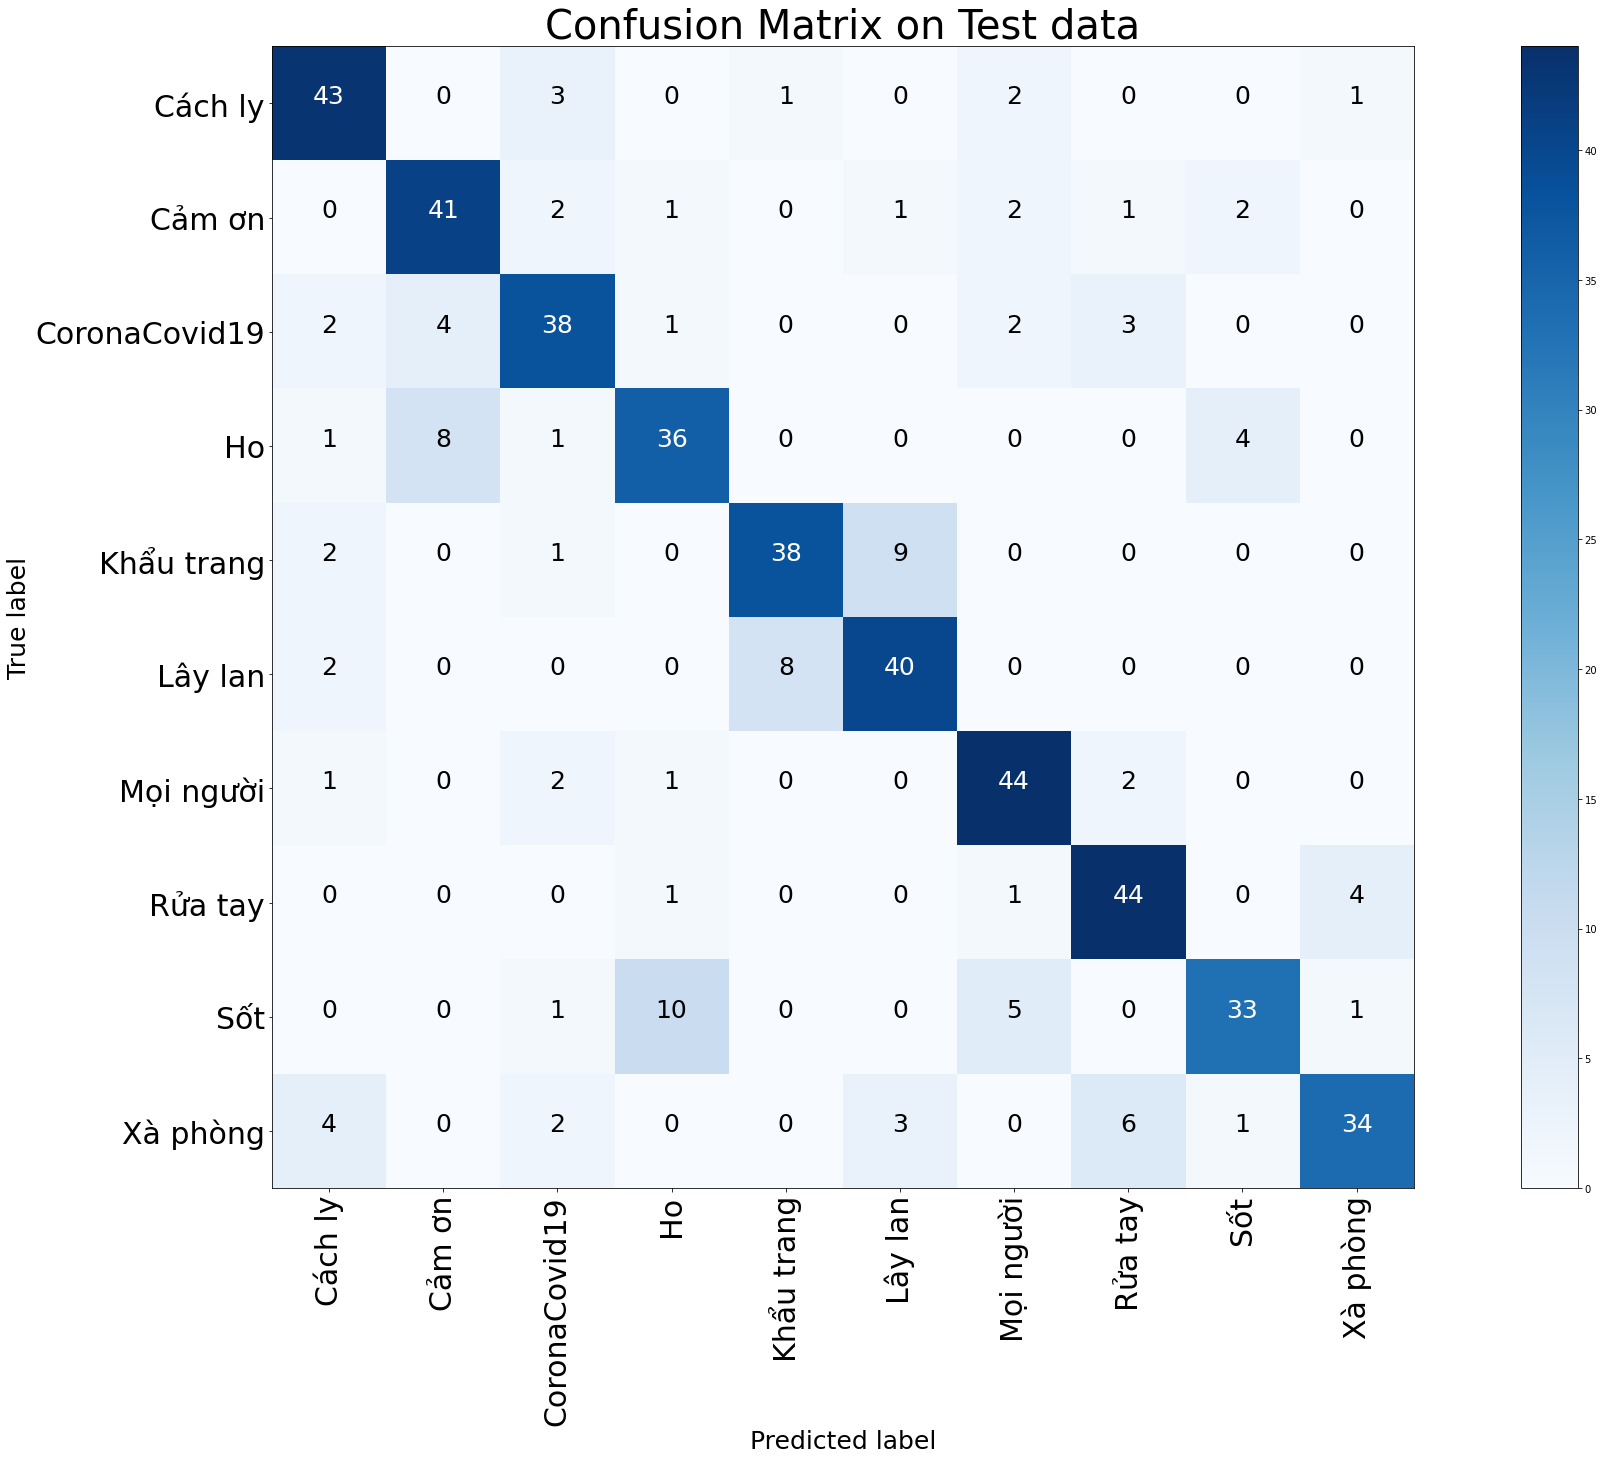

In [36]:
plt.figure(figsize=(30,20))
class_names = ['Cách ly', 'Cảm ơn', 'CoronaCovid19', 'Ho', 'Khẩu trang', 'Lây lan', 'Mọi người', 'Rửa tay', 'Sốt', 'Xà phòng']

plot_confusion_matrix(cfm, classes=class_names, title='Confusion Matrix on Test data')
plt.show()

## Confusion matrix on far test set

In [37]:
dirname = '/home/shayneysang98/HCMUT/Thesis/Sign-language-recognition-with-RNN-and-Mediapipe/testmohinh/far_test_out/Relative/'
x_test,y_test=load_testdata(dirname)
new_model = tf.keras.models.load_model('modeltest1.h5')
xhat = x_test
yhat = new_model.predict(xhat)

In [38]:
cfm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(yhat, axis=1))

In [39]:
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[ 6  0  1  0  0  2  0  0  0  1]
 [ 0  4  6  0  0  0  0  0  0  0]
 [ 2  0  7  0  0  1  0  0  0  0]
 [ 0  4  1  4  0  0  1  0  0  0]
 [ 0  0  0  0 10  0  0  0  0  0]
 [ 0  0  0  0  2  8  0  0  0  0]
 [ 0  0  1  0  0  0  7  1  1  0]
 [ 0  0  0  0  0  0  0  9  0  1]
 [ 0  0  1  1  0  0  2  0  5  0]
 [ 1  0  0  0  0  0  2  3  0  4]]


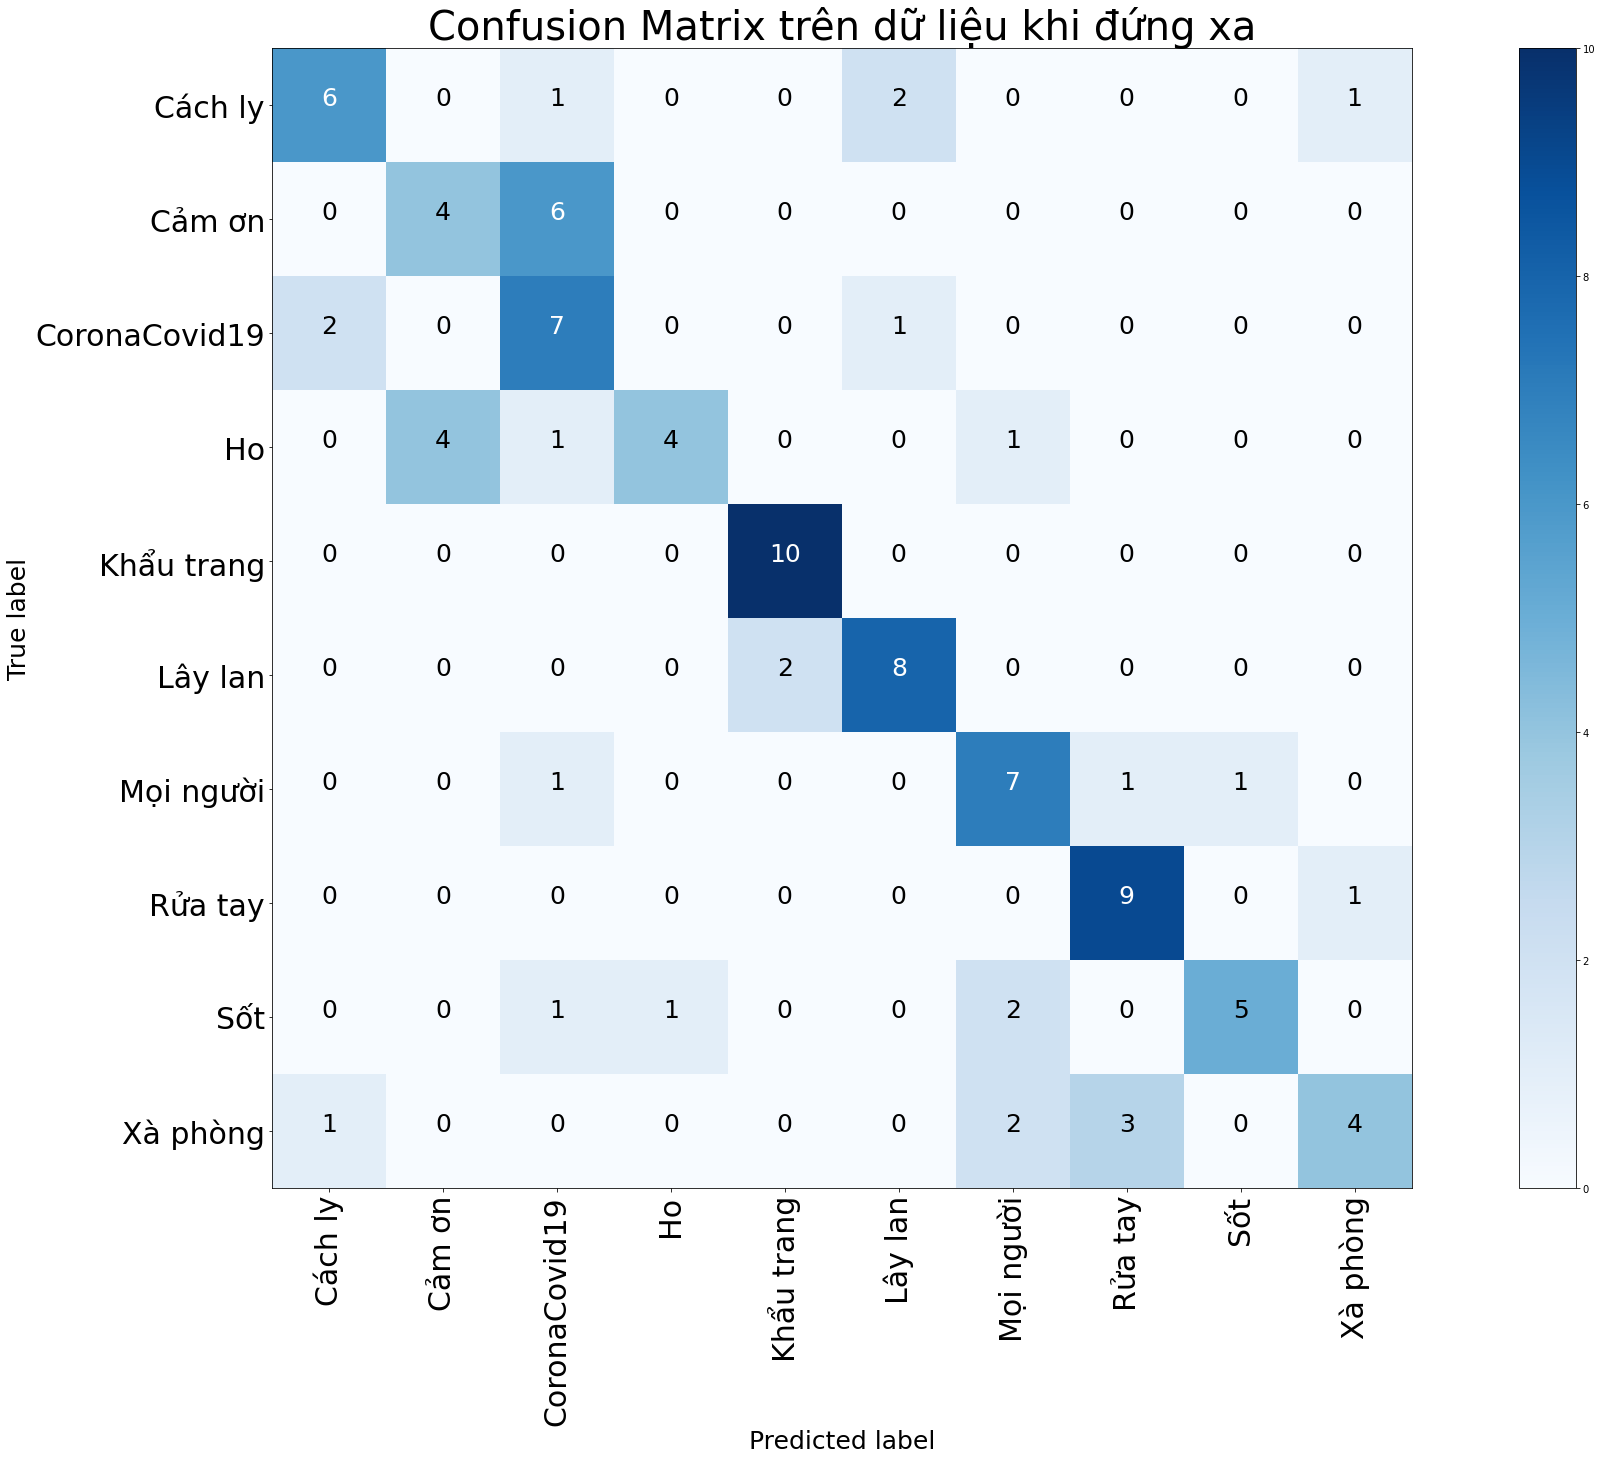

In [40]:
plt.figure(figsize=(30,20))
class_names = ['Cách ly', 'Cảm ơn', 'CoronaCovid19', 'Ho', 'Khẩu trang', 'Lây lan', 'Mọi người', 'Rửa tay', 'Sốt', 'Xà phòng']

plot_confusion_matrix(cfm, classes=class_names, title='Confusion Matrix trên dữ liệu khi đứng xa')
plt.show()